In [1]:
from pathlib import Path
import pandas as pd

IMDB_CSV = Path("/content/drive/MyDrive/AMDA/Movies_Reviews_modified_version1.csv")
assert IMDB_CSV.exists(), f"Nu găsesc fișierul: {IMDB_CSV.resolve()}"

imdb = pd.read_csv(IMDB_CSV)
imdb.head()


,Unnamed: 0,Ratings,Reviews,movie_name,Resenhas,genres,Description,emotion
0,0,3.0,"It had some laughs, but overall the motivation...",Waiting to Exhale,"Riu algumas risadas, mas no geral a motivação ...","['Comedy', 'Drama', 'Romance']","Based on Terry McMillan's novel, this film fol...",anticipation
1,1,4.0,"WAITING TO EXHALE Waiting, and waiting, and wa...",Waiting to Exhale,"ESPERANDO PARA EXALAR Esperando, e esperando, ...","['Comedy', 'Drama', 'Romance']","Based on Terry McMillan's novel, this film fol...",anticipation
2,2,4.0,"Angela Basset was good as expected, but Whitne...",Waiting to Exhale,"Angela Basset foi boa como o esperado, mas Whi...","['Comedy', 'Drama', 'Romance']","Based on Terry McMillan's novel, this film fol...",anticipation
3,3,5.0,"The movie is okay, mediocre might even be the ...",Waiting to Exhale,"O filme é bom, medíocre pode até ser a palavra...","['Comedy', 'Drama', 'Romance']","Based on Terry McMillan's novel, this film fol...",anticipation
4,4,5.0,I got an opportunity to see Waiting To Exhale ...,Waiting to Exhale,Tive a oportunidade de ver Waiting To Exhale p...,"['Comedy', 'Drama', 'Romance']","Based on Terry McMillan's novel, this film fol...",anticipation


In [2]:
print(imdb.info())
print("\nColoane disponibile:", list(imdb.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46173 entries, 0 to 46172
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   46173 non-null  int64  
 1   Ratings      46173 non-null  float64
 2   Reviews      46173 non-null  object 
 3   movie_name   46173 non-null  object 
 4   Resenhas     46173 non-null  object 
 5   genres       46173 non-null  object 
 6   Description  46173 non-null  object 
 7   emotion      46173 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.8+ MB
None

Coloane disponibile: ['Unnamed: 0', 'Ratings', 'Reviews', 'movie_name', 'Resenhas', 'genres', 'Description', 'emotion']


In [3]:
# Distribuția emoțiilor
print("Distribuția valorilor în 'emotion':")
print(imdb['emotion'].value_counts(dropna=False))

# Lungimea descrierilor (număr de cuvinte)
imdb['desc_len'] = imdb['Description'].astype(str).str.split().apply(len)
print("\nStatistici pentru lungimea descrierilor:")
print(imdb['desc_len'].describe())

# 5 exemple random
imdb[['movie_name', 'genres', 'Description', 'emotion']].sample(5, random_state=42)


Distribuția valorilor în 'emotion':
emotion
sadness         17339
joy              7861
anticipation     7336
optimism         4812
anger            3638
fear             3460
disgust          1670
surprise           57
Name: count, dtype: int64

Statistici pentru lungimea descrierilor:
count    46173.000000
mean        26.163645
std         10.588729
min          2.000000
25%         19.000000
50%         27.000000
75%         35.000000
max         64.000000
Name: desc_len, dtype: float64


,movie_name,genres,Description,emotion
34351,Love,"['Drama', 'Romance']",LOVE explores the relationship between friends...,sadness
4422,Sleeping Beauty,"['Fantasy', 'Animation', 'Romance', 'Family']","After being snubbed by the royal family, a mal...",sadness
26394,The Raven,"['Crime', 'Thriller', 'Mystery']",Add a Plot,anticipation
37414,Underground,['Documentary'],A working-class love story set in and around t...,joy
7950,The Fast and the Furious,"['Action', 'Crime', 'Thriller']",A trucker framed for murder breaks out of jail...,fear


/tmp/ipython-input-1513506922.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


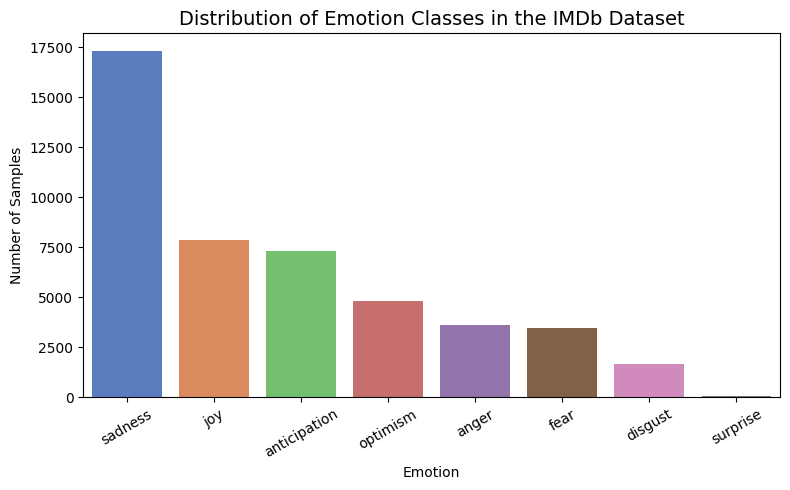

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(
    x=imdb['emotion'],
    order=imdb['emotion'].value_counts().index,
    palette="muted"
)

plt.title("Distribution of Emotion Classes in the IMDb Dataset", fontsize=14)
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [5]:
# facem o copie ca să nu stricăm tabelul original
df = imdb.copy()

# 1) eliminăm clasa "surprise" care are doar 57 rânduri
df = df[df['emotion'] != 'surprise'].copy()

# 2) eliminăm duplicatele IDENTICE (bazate pe featuresle relevante)
df = df.drop_duplicates(
    subset=['movie_name', 'Description', 'genres', 'emotion'],
    keep='first'
).copy()

# 3) eliminăm descrierile foarte scurte (inutile pentru clasificare)
df['desc_len'] = df['Description'].astype(str).str.split().apply(len)
df = df[df['desc_len'] >= 3].copy()

# 4) resetăm indexul
df = df.reset_index(drop=True)

# verificare finală
print("Dimensiune după curățare:", df.shape)
print("\nDistribuție emoții după curățare:")
print(df['emotion'].value_counts())


Dimensiune după curățare: (3609, 9)

Distribuție emoții după curățare:
emotion
sadness         1371
joy              651
anticipation     565
optimism         374
fear             274
anger            246
disgust          128
Name: count, dtype: int64


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# asigurăm resursele
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# stopwords EN
stop_words = set(stopwords.words('english'))

# păstrăm negările -> le eliminăm din stopwords
negations = {"not", "no", "nor", "never", "n't"}
stop_words = {w for w in stop_words if w not in negations}

lemmatizer = WordNetLemmatizer()

def clean_text(text: str, do_stop=True, do_lemma=True):
    # lowercase
    text = text.lower()

    # eliminăm linkuri
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # eliminăm caractere non-alfabetice
    text = re.sub(r'[^a-z\s]', ' ', text)

    # tokenizare simplă
    tokens = text.split()

    # eliminăm stopwords
    if do_stop:
        tokens = [t for t in tokens if t not in stop_words]

    # lematizare
    if do_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

# aplicăm pe dataset
df['clean_preproc'] = df['Description'].astype(str).apply(lambda x: clean_text(x, True, True))
df['clean_minimal'] = df['Description'].astype(str).apply(lambda x: clean_text(x, False, False))

df[['Description','clean_preproc','clean_minimal']].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,Description,clean_preproc,clean_minimal
0,"Based on Terry McMillan's novel, this film fol...",based terry mcmillan novel film follows four d...,based on terry mcmillan s novel this film foll...
1,George Banks must deal not only with his daugh...,george bank must deal not daughter pregnancy a...,george banks must deal not only with his daugh...
2,Spoof of the casual sexual adventures of a one...,spoof casual sexual adventure one time child a...,spoof of the casual sexual adventures of a one...
3,A playboy becomes interested in the daughter o...,playboy becomes interested daughter family cha...,a playboy becomes interested in the daughter o...
4,An ugly duckling having undergone a remarkable...,ugly duckling undergone remarkable change stil...,an ugly duckling having undergone a remarkable...
5,Two best friends witness a murder and embark o...,two best friend witness murder embark series a...,two best friends witness a murder and embark o...
6,"Rich Mr. Dashwood dies, leaving his second wif...",rich mr dashwood dy leaving second wife three ...,rich mr dashwood dies leaving his second wife ...
7,"Ben Sanderson, a Hollywood screenwriter who lo...",ben sanderson hollywood screenwriter lost ever...,ben sanderson a hollywood screenwriter who los...
8,Alyssa and Amanda are two little girls who are...,alyssa amanda two little girl identical comple...,alyssa and amanda are two little girls who are...
9,"In Texas, the naive Travis Rogers quits his jo...",texas naive travis rogers quits job marry belo...,in texas the naive travis rogers quits his job...


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import numpy as np

def run_experiment_mc(
    text_series: pd.Series,      # coloana cu text (ex: df['clean_preproc'])
    labels: pd.Series,          # etichetele (ex: df['emotion'])
    vec_type: str = 'tfidf',    # 'tfidf' sau 'count'
    max_features: int = 5000,   # mărimea vocabularului
    ngram_range=(1,2),          # unigrame + bigrame implicit
    model_type: str = 'multinomial',  # 'multinomial' sau 'bernoulli'
    alpha: float = 1.0,
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Rulează un experiment de clasificare multi-clasă (emoții) pe text.
    Returnează scoruri + model + vectorizator + y_test/y_pred.
    """

    # 0) split pe text brut (evităm data leakage)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        text_series.astype(str).values,
        labels.values,
        test_size=test_size,
        random_state=random_state,
        stratify=labels.values   # păstrăm distribuția emoțiilor
    )

    # 1) Alegem vectorizatorul
    if vec_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )
    elif vec_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            binary=(model_type == 'bernoulli')  # pentru Bernoulli folosim 0/1
        )
    else:
        raise ValueError("vec_type trebuie să fie 'tfidf' sau 'count'")

    # 2) Învață vocabularul pe train, transformă train + test
    X_train = vectorizer.fit_transform(X_train_text)
    X_test  = vectorizer.transform(X_test_text)

    # 3) Alegem modelul Naive Bayes
    if model_type == 'multinomial':
        model = MultinomialNB(alpha=alpha)
    elif model_type == 'bernoulli':
        model = BernoulliNB(alpha=alpha)
    else:
        raise ValueError("model_type trebuie 'multinomial' sau 'bernoulli'")

    # 4) Antrenăm modelul
    model.fit(X_train, y_train)

    # 5) Predicții
    y_pred = model.predict(X_test)

    # 6) Metrici:
    #  - accuracy generală
    #  - macro precision/recall/F1 (media pe clase, le tratează egal)
    acc = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred,
        average='macro',
        zero_division=0
    )

    # optional: weighted F1 (ține cont de frecvența fiecărei clase)
    _, _, f1_weighted, _ = precision_recall_fscore_support(
        y_test, y_pred,
        average='weighted',
        zero_division=0
    )

    # matrice de confuzie
    cm = confusion_matrix(y_test, y_pred)

    # classification report complet (pe clase)
    cls_report = classification_report(
        y_test, y_pred, digits=4
    )

    return {
        'acc': acc,
        'precision_macro': prec_macro,
        'recall_macro': rec_macro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'cm': cm,
        'cls_report': cls_report,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': model,
        'vectorizer': vectorizer
    }


In [8]:
res_imdb_A = run_experiment_mc(
    text_series=df['clean_preproc'],
    labels=df['emotion'],
    vec_type='tfidf',
    max_features=5000,
    ngram_range=(1,2),
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_imdb_A['acc'], 4),
    'Precision_macro': round(res_imdb_A['precision_macro'], 4),
    'Recall_macro': round(res_imdb_A['recall_macro'], 4),
    'F1_macro': round(res_imdb_A['f1_macro'], 4),
    'F1_weighted': round(res_imdb_A['f1_weighted'], 4),
})

print("\nClassification report pe emoții:\n")
print(res_imdb_A['cls_report'])


{'Accuracy': 0.5928, 'Precision_macro': 0.9081, 'Recall_macro': 0.3794, 'F1_macro': 0.4399, 'F1_weighted': 0.548}

Classification report pe emoții:

              precision    recall  f1-score   support

       anger     1.0000    0.2653    0.4194        49
anticipation     0.9833    0.5221    0.6821       113
     disgust     1.0000    0.1154    0.2069        26
        fear     1.0000    0.1273    0.2258        55
         joy     0.8841    0.4692    0.6131       130
    optimism     1.0000    0.1600    0.2759        75
     sadness     0.4892    0.9964    0.6562       274

    accuracy                         0.5928       722
   macro avg     0.9081    0.3794    0.4399       722
weighted avg     0.7827    0.5928    0.5480       722



In [9]:
res_imdb_A_count = run_experiment_mc(
    text_series=df['clean_preproc'],
    labels=df['emotion'],
    vec_type='count',       # 🔁 schimbăm TF-IDF cu CountVectorizer
    max_features=5000,
    ngram_range=(1,2),      # păstrăm unigrame + bigrame, ca în A
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_imdb_A_count['acc'], 4),
    'Precision_macro': round(res_imdb_A_count['precision_macro'], 4),
    'Recall_macro': round(res_imdb_A_count['recall_macro'], 4),
    'F1_macro': round(res_imdb_A_count['f1_macro'], 4),
    'F1_weighted': round(res_imdb_A_count['f1_weighted'], 4),
})

print("\nClassification report pe emoții (Count):\n")
print(res_imdb_A_count['cls_report'])


{'Accuracy': 0.7008, 'Precision_macro': 0.7888, 'Recall_macro': 0.5687, 'F1_macro': 0.6325, 'F1_weighted': 0.6882}

Classification report pe emoții (Count):

              precision    recall  f1-score   support

       anger     0.9130    0.4286    0.5833        49
anticipation     0.7788    0.7168    0.7465       113
     disgust     0.9000    0.3462    0.5000        26
        fear     0.8214    0.4182    0.5542        55
         joy     0.7155    0.6385    0.6748       130
    optimism     0.7500    0.5200    0.6142        75
     sadness     0.6427    0.9124    0.7541       274

    accuracy                         0.7008       722
   macro avg     0.7888    0.5687    0.6325       722
weighted avg     0.7295    0.7008    0.6882       722



In [10]:
res_imdb_A_count_uni = run_experiment_mc(
    text_series=df['clean_preproc'],
    labels=df['emotion'],
    vec_type='count',       # CountVectorizer
    max_features=5000,
    ngram_range=(1,1),      # 🔁 DOAR unigrame aici
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_imdb_A_count_uni['acc'], 4),
    'Precision_macro': round(res_imdb_A_count_uni['precision_macro'], 4),
    'Recall_macro': round(res_imdb_A_count_uni['recall_macro'], 4),
    'F1_macro': round(res_imdb_A_count_uni['f1_macro'], 4),
    'F1_weighted': round(res_imdb_A_count_uni['f1_weighted'], 4),
})

print("\nClassification report pe emoții (Count + unigrame):\n")
print(res_imdb_A_count_uni['cls_report'])


{'Accuracy': 0.7258, 'Precision_macro': 0.8113, 'Recall_macro': 0.5981, 'F1_macro': 0.6643, 'F1_weighted': 0.7151}

Classification report pe emoții (Count + unigrame):

              precision    recall  f1-score   support

       anger     0.9286    0.5306    0.6753        49
anticipation     0.7981    0.7345    0.7650       113
     disgust     0.8182    0.3462    0.4865        26
        fear     0.8667    0.4727    0.6118        55
         joy     0.7478    0.6615    0.7020       130
    optimism     0.8636    0.5067    0.6387        75
     sadness     0.6564    0.9343    0.7711       274

    accuracy                         0.7258       722
   macro avg     0.8113    0.5981    0.6643       722
weighted avg     0.7569    0.7258    0.7151       722



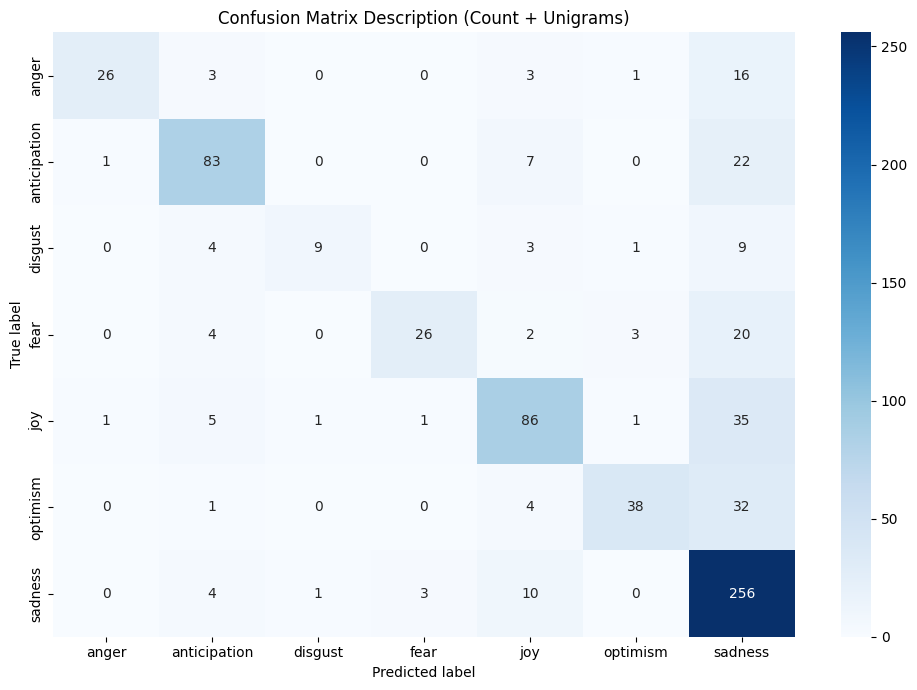

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# extragem valori reale și prezise
y_true = res_imdb_A_count_uni['y_test']
y_pred = res_imdb_A_count_uni['y_pred']

# definim ordinea claselor EXACT ca în dataset
emotion_labels = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'optimism', 'sadness']

# construim matricea de confuzie
cm = confusion_matrix(y_true, y_pred, labels=emotion_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Description (Count + Unigrams)")
plt.tight_layout()
plt.show()


Model2

In [11]:
import ast

def clean_genres(genres_value):
    """
    Transformă string-ul genurilor în listă reală,
    apoi îl convertește în text simplu (ex: 'Drama Romance Thriller')
    """
    try:
        genres_list = ast.literal_eval(genres_value)  # convertește string -> listă
        if isinstance(genres_list, list):
            # curățăm spațiile, punem totul lowercase
            genres_list = [g.lower().strip() for g in genres_list]
            return " ".join(genres_list)
        else:
            return ""
    except Exception:
        return ""

df['genres_clean'] = df['genres'].apply(clean_genres)

df[['genres', 'genres_clean']].head(10)


,genres,genres_clean
0,"['Comedy', 'Drama', 'Romance']",comedy drama romance
1,['Comedy'],comedy
2,"['Action', 'Crime', 'Drama', 'Thriller']",action crime drama thriller
3,"['Comedy', 'Romance']",comedy romance
4,"['Comedy', 'Romance']",comedy romance
5,"['Action', 'Adventure', 'Drama', 'Family']",action adventure drama family
6,"['Drama', 'Romance']",drama romance
7,"['Drama', 'Romance']",drama romance
8,"['Comedy', 'Family', 'Romance']",comedy family romance
9,"['Comedy', 'Family', 'Romance']",comedy family romance


In [12]:
# Construim textul combinat pentru Modelul B
df['desc_plus_gen'] = df['clean_preproc'] + " " + df['genres_clean']

df[['clean_preproc', 'genres_clean', 'desc_plus_gen']].head(10)


,clean_preproc,genres_clean,desc_plus_gen
0,based terry mcmillan novel film follows four d...,comedy drama romance,based terry mcmillan novel film follows four d...
1,george bank must deal not daughter pregnancy a...,comedy,george bank must deal not daughter pregnancy a...
2,spoof casual sexual adventure one time child a...,action crime drama thriller,spoof casual sexual adventure one time child a...
3,playboy becomes interested daughter family cha...,comedy romance,playboy becomes interested daughter family cha...
4,ugly duckling undergone remarkable change stil...,comedy romance,ugly duckling undergone remarkable change stil...
5,two best friend witness murder embark series a...,action adventure drama family,two best friend witness murder embark series a...
6,rich mr dashwood dy leaving second wife three ...,drama romance,rich mr dashwood dy leaving second wife three ...
7,ben sanderson hollywood screenwriter lost ever...,drama romance,ben sanderson hollywood screenwriter lost ever...
8,alyssa amanda two little girl identical comple...,comedy family romance,alyssa amanda two little girl identical comple...
9,texas naive travis rogers quits job marry belo...,comedy family romance,texas naive travis rogers quits job marry belo...


In [13]:
# Model B1: descriere + genuri, CountVectorizer, unigrame
res_B1 = run_experiment_mc(
    text_series=df['desc_plus_gen'],
    labels=df['emotion'],
    vec_type='count',
    max_features=5000,
    ngram_range=(1,1),      # unigrame doar
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_B1['acc'], 4),
    'Precision_macro': round(res_B1['precision_macro'], 4),
    'Recall_macro': round(res_B1['recall_macro'], 4),
    'F1_macro': round(res_B1['f1_macro'], 4),
    'F1_weighted': round(res_B1['f1_weighted'], 4),
})

print("\nClassification report – Model B1 (desc + genres):\n")
print(res_B1['cls_report'])


{'Accuracy': 0.7161, 'Precision_macro': 0.8282, 'Recall_macro': 0.5756, 'F1_macro': 0.6455, 'F1_weighted': 0.7029}

Classification report – Model B1 (desc + genres):

              precision    recall  f1-score   support

       anger     0.9259    0.5102    0.6579        49
anticipation     0.7830    0.7345    0.7580       113
     disgust     0.8750    0.2692    0.4118        26
        fear     0.9286    0.4727    0.6265        55
         joy     0.7736    0.6308    0.6949       130
    optimism     0.8750    0.4667    0.6087        75
     sadness     0.6364    0.9453    0.7606       274

    accuracy                         0.7161       722
   macro avg     0.8282    0.5756    0.6455       722
weighted avg     0.7593    0.7161    0.7029       722



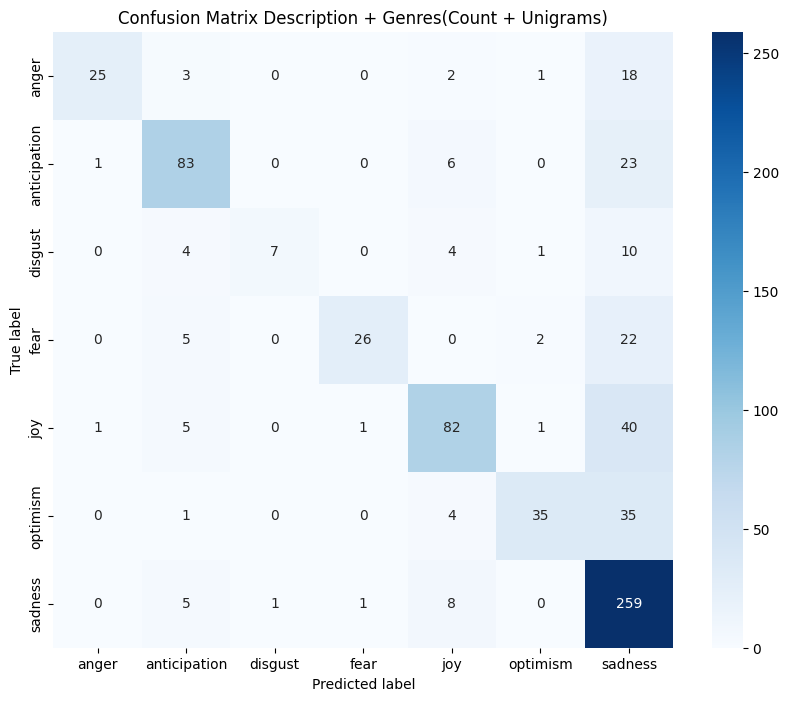

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# extragem matricea de confuzie
cm_B1 = confusion_matrix(res_B1['y_test'], res_B1['y_pred'])

# etichetele claselor în ordinea corectă
emotion_labels = ["anger", "anticipation", "disgust", "fear", "joy", "optimism", "sadness"]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_B1,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=emotion_labels,
    yticklabels=emotion_labels
)

plt.title("Confusion Matrix Description + Genres(Count + Unigrams)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [14]:
# Model B2: descriere + genuri, CountVectorizer cu bigrame (1,2)
res_B2 = run_experiment_mc(
    text_series=df['desc_plus_gen'],
    labels=df['emotion'],
    vec_type='count',
    max_features=5000,
    ngram_range=(1,2),      # unigrame + bigrame
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_B2['acc'], 4),
    'Precision_macro': round(res_B2['precision_macro'], 4),
    'Recall_macro': round(res_B2['recall_macro'], 4),
    'F1_macro': round(res_B2['f1_macro'], 4),
    'F1_weighted': round(res_B2['f1_weighted'], 4),
})

print("\nClassification report – Model B2 (desc + genres, bigrams):\n")
print(res_B2['cls_report'])


{'Accuracy': 0.6939, 'Precision_macro': 0.7894, 'Recall_macro': 0.5549, 'F1_macro': 0.6178, 'F1_weighted': 0.68}

Classification report – Model B2 (desc + genres, bigrams):

              precision    recall  f1-score   support

       anger     0.9545    0.4286    0.5915        49
anticipation     0.7297    0.7168    0.7232       113
     disgust     0.8750    0.2692    0.4118        26
        fear     0.8214    0.4182    0.5542        55
         joy     0.7297    0.6231    0.6722       130
    optimism     0.7800    0.5200    0.6240        75
     sadness     0.6352    0.9088    0.7477       274

    accuracy                         0.6939       722
   macro avg     0.7894    0.5549    0.6178       722
weighted avg     0.7266    0.6939    0.6800       722



In [15]:
# Model B3: descriere + genuri, TF-IDF, unigrame
res_B3 = run_experiment_mc(
    text_series=df['desc_plus_gen'],
    labels=df['emotion'],
    vec_type='tfidf',
    max_features=5000,
    ngram_range=(1,1),
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_B3['acc'], 4),
    'Precision_macro': round(res_B3['precision_macro'], 4),
    'Recall_macro': round(res_B3['recall_macro'], 4),
    'F1_macro': round(res_B3['f1_macro'], 4),
    'F1_weighted': round(res_B3['f1_weighted'], 4),
})

print("\nClassification report – Model B3 (TF-IDF + genres + unigrams):\n")
print(res_B3['cls_report'])


{'Accuracy': 0.5554, 'Precision_macro': 0.903, 'Recall_macro': 0.3308, 'F1_macro': 0.375, 'F1_weighted': 0.4984}

Classification report – Model B3 (TF-IDF + genres + unigrams):

              precision    recall  f1-score   support

       anger     1.0000    0.1429    0.2500        49
anticipation     0.9833    0.5221    0.6821       113
     disgust     1.0000    0.0385    0.0741        26
        fear     1.0000    0.1273    0.2258        55
         joy     0.8723    0.3154    0.4633       130
    optimism     1.0000    0.1733    0.2955        75
     sadness     0.4651    0.9964    0.6341       274

    accuracy                         0.5554       722
   macro avg     0.9030    0.3308    0.3750       722
weighted avg     0.7714    0.5554    0.4984       722



In [16]:
# Model B4: descriere + genuri, TF-IDF, unigrame + bigrame
res_B4 = run_experiment_mc(
    text_series=df['desc_plus_gen'],
    labels=df['emotion'],
    vec_type='tfidf',
    max_features=5000,
    ngram_range=(1,2),
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_B4['acc'], 4),
    'Precision_macro': round(res_B4['precision_macro'], 4),
    'Recall_macro': round(res_B4['recall_macro'], 4),
    'F1_macro': round(res_B4['f1_macro'], 4),
    'F1_weighted': round(res_B4['f1_weighted'], 4),
})

print("\nClassification report – Model B4 (TF-IDF + genres + bigrams):\n")
print(res_B4['cls_report'])


{'Accuracy': 0.5623, 'Precision_macro': 0.9085, 'Recall_macro': 0.3386, 'F1_macro': 0.3866, 'F1_weighted': 0.509}

Classification report – Model B4 (TF-IDF + genres + bigrams):

              precision    recall  f1-score   support

       anger     1.0000    0.2041    0.3390        49
anticipation     0.9818    0.4779    0.6429       113
     disgust     1.0000    0.0385    0.0741        26
        fear     1.0000    0.1091    0.1967        55
         joy     0.9091    0.3846    0.5405       130
    optimism     1.0000    0.1600    0.2759        75
     sadness     0.4683    0.9964    0.6371       274

    accuracy                         0.5623       722
   macro avg     0.9085    0.3386    0.3866       722
weighted avg     0.7790    0.5623    0.5090       722

